In [2]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import *
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import *
# from dataProcessingHelpers import sliding_window
from numpy.lib.stride_tricks import sliding_window_view
import os
import matplotlib.pyplot as plt
from helpers import get_NWP_data, sw_func,find_experiment_directory,create_dataset

In [3]:


def rename_append(x): return (lambda a: str(a) + x)


def get_future_hour(x): return (
    x.index + datetime.timedelta(hours=int(x.name))).hour


def sliding_window(a, window):
    from numpy.lib.stride_tricks import as_strided
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return as_strided(a, shape=shape, strides=strides)

class mean_error():
    def __init__(self, axis, agg_func, name):
        self.axis = axis
        self.agg_func = agg_func
        self.name = name

In [4]:

# Fixed paramters
project = "Final Thesis Experiment"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 600, 800, 1000],
    "RVK-BOD": [0, 25, 50, 75, 100, 125, 150, 200],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

# District heating model settings
cross_validation = {
    "fn_kfold": fn_kfold,
    "folds": folds,
}


experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

class emptyclass():
    def __init__(self):
        pass
args = emptyclass
args.alpha = 0
args.datasource = 'gauge'
args.include = 'r'
args.weights = 'same'
args.obs = 20
n_obs = args.obs



early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 200,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }
config_conceptual = {
    "name": "Conceptual model",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    'lr_inital_log': 1,
    'lr_final_log': -4.5,
    'lr_intervals': 100,
    'batch_size': 10,
    'epochs': 10,
    'random_seed':0,
    'pred_dist':pred_dist,
    'include' : 'rth',
}


In [5]:
obs = n_obs
URL_save_data = None
gauge_name = '1475_R_manual'




GD_dirname = find_experiment_directory()
if type(URL_save_data) != type(None):
    GD_dirname = URL_save_data
drainage_names = np.array(list(threshold_dict.keys()))


In [131]:
f'{GD_dirname}/Data/rain_gauges_combined.pkl'

'C:\\Users\\sverrirhd\\Google Drive\\Skóli\\DTU\\Thesis\\Programming\\Experiments/Data/rain_gauges_combined.pkl'

In [130]:
pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    

,1473_R_raw,1474_R_raw,1475_R_raw,1478_R_raw,1481_R_raw,1482_R_raw,1485_R_raw,1578_R_raw,1473_R_manual,1474_R_manual,1475_R_manual,1478_R_manual,1485_R_manual
TIMI,,,,,,,,,,,,,
2005-08-22 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.2,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-22 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03 09:00:00,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN
2021-06-03 10:00:00,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.20,NaN,NaN,NaN,NaN,NaN
2021-06-03 11:00:00,0.0,0.0,0.60,0.0,0.0,0.0,0.0,0.20,NaN,NaN,NaN,NaN,NaN


In [6]:

# def get_rain_gauge_or_radar_data(threshold_dict,
#                                  temperature_name,
#                                  obs,
#                                  d_start,d_end,
#                                  URL_save_data = None,
#                                  gauge_name = '1475_R_manual'):
# Radar data
# df_radar = np.load(f'{GD_dirname}/Data/20x20cappi_rainfall.pkl',allow_pickle=True)
df_radar = np.load(f'{GD_dirname}/Data/20x20cappi_rainfall_1_25_to_2018.pkl',allow_pickle=True)

# rain_gauge data
df_gauge = pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    

# Temperature data (Added '_T' to differentiate between temperature and rain-gauge data)
df_temperature = pd.read_pickle(f'{GD_dirname}/Data/temperature_data.pkl').rename(rename_append('_T'), axis=1)

# Drainage flow data (Drop MOS-HOl and KOP-HAB since they are irrelevant)
df_target = pd.read_pickle(f'{GD_dirname}/Data/drainage_Flow.pkl').drop(['MOS-HOL', 'KOP-HAB'], axis=1)

Y_all = df_target.loc[d_start:d_end, drainage_names].copy()

Xt_all = df_temperature.loc[d_start:d_end, temperature_name]#X.loc[d_start:d_end,temperature_name].copy()
Xrg_all = df_gauge.loc[d_start:d_end,gauge_name].copy()
Xra_all = df_radar.loc[d_start:d_end].copy()



[Xt_all_seq_dirty,Y_all_seq_dirty,Xra_all_seq_dirty,Xrg_all_seq_dirty],dates_all_seq_dirty =\
    create_dataset([Xt_all,Y_all,Xra_all,Xrg_all],obs)
# Because of the .squeeze() in the create dataset, this id done to standardize the shapes
n = len(Xt_all_seq_dirty)
Xt_all_seq_dirty = Xt_all_seq_dirty.reshape(n,-1,1)
Y_all_seq_dirty = Y_all_seq_dirty.reshape(n,-1,2)
Xra_all_seq_dirty = Xra_all_seq_dirty.reshape(n,-1,400)
Xrg_all_seq_dirty = Xrg_all_seq_dirty.reshape(n,-1,1)

# Take all but last value away from data where lagged value isn't necessary
if type(Y_all_seq_dirty) == list:
    Y_all_seq_dirty = np.concatenate([i[:,:,np.newaxis] for i in Y_all_seq_dirty],axis=2)

Y_all_seq_dirty = Y_all_seq_dirty[:,-1]

# Drop rows with missing input data or all output data missing
nan_rows = np.isnan(Xt_all_seq_dirty).any(axis=1).ravel() |\
    np.isnan(Xra_all_seq_dirty).any(axis=(1,2)).ravel() |\
        np.isnan(Xrg_all_seq_dirty).any(axis=1).ravel() |\
            np.isnan(Y_all_seq_dirty).any(axis=1).ravel()

good_rows = ~nan_rows
Xt_all_seq = Xt_all_seq_dirty[good_rows]
Xra_all_seq = Xra_all_seq_dirty[good_rows]
Xrg_all_seq = Xrg_all_seq_dirty[good_rows]

Xt_all_single = Xt_all_seq_dirty[good_rows][:,-1]
Xra_all_single = Xra_all_seq_dirty[good_rows][:,-1]
Xrg_all_single = Xrg_all_seq_dirty[good_rows][:,-1]

Y_all_single = Y_all_seq_dirty[good_rows]

dates_all_seq = dates_all_seq_dirty[good_rows]

hour_ohe_seq = OneHotEncoder().fit_transform(pd.DatetimeIndex(dates_all_seq.ravel()).hour.values.reshape(-1,1))
hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1,obs,24)
hour_ohe_single = hour_ohe_seq[:,-1]

X1a = Xra_all_seq
X1b = Xrg_all_seq
X2 = Xt_all_seq
X3 = hour_ohe_seq
Y12 = Y_all_single

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sverrirhd\\Google Drive\\Skóli\\DTU\\Thesis\\Programming\\Experiments/Data/20x20cappi_rainfall_1_25_to_2018.pkl'

In [ ]:
_,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
    threshold_dict,
    temperature_name,
    n_obs,
    d_start,d_end)
rain_shape = (-1, n_obs, 1)
temp_shape = (-1, n_obs, 1)
patt_shape = (-1, n_obs, 24)

In [8]:
drainage_names = np.array(list(threshold_dict.keys()))

# Radar data
# df_radar = np.load(f'{GD_dirname}/Data/20x20cappi_rainfall.pkl',allow_pickle=True)
# df_radar = np.load(f'{GD_dirname}/Data/20x20cappi_rainfall.pkl',allow_pickle=True)

df_radar = np.load(f'../Radar - runoff/20x20cappi_rainfall_1_25_to_2018.pkl',allow_pickle=True)

# rain_gauge data
df_gauge = pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    

# Temperature data (Added '_T' to differentiate between temperature and rain-gauge data)
df_temperature = pd.read_pickle(f'{GD_dirname}/Data/temperature_data.pkl').rename(rename_append('_T'), axis=1)

# Drainage flow data (Drop MOS-HOl and KOP-HAB since they are irrelevant)
df_target = pd.read_pickle(f'{GD_dirname}/Data/drainage_Flow.pkl').drop(['MOS-HOL', 'KOP-HAB'], axis=1)


In [9]:
df_cold = pd.read_csv('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Drainage data/coldwater.csv')
df_cold.CTime = pd.to_datetime(df_cold.CTime)
df_cold = df_cold.loc[df_cold.CTime >= datetime.datetime(2015,1,1)]
df_cold_wide = df_cold.pivot_table(values = 'Val',columns = 'Name',index = 'CTime')

# rvk_columns = [col for col in df_cold_wide.columns if 'RVK' in col]
# df_cold_wide = df_cold_wide.loc[:,rvk_columns]

In [10]:
cold_cols = df_cold_wide.columns

In [11]:
import re
for col in cold_cols:
    meter_name = re.findall('RS[0-9]*$',col)[0][2:]
    building_id_1 = re.findall('-[0-9]*-',col)[0][1:-1]
    building_id_2 = re.findall('^K[0-9]*VRÁS',col)
    print(col,meter_name,building_id_1,building_id_2)

K-RVK-001-RS113 113 001 []
K-RVK-001-RS114 114 001 []
K-RVK-001-RS211 211 001 []
K-RVK-001-RS212 212 001 []
K-RVK-001-RS5101 5101 001 []
K-RVK-001-RS5201 5201 001 []
K-RVK-001-RS5301 5301 001 []
K-RVK-001-RS5401 5401 001 []
K-RVK-001-RS5901 5901 001 []
K-RVK-002-RS211 211 002 []
K-RVK-002-RS221 221 002 []
K-RVK-002-RS231 231 002 []
K-RVK-002-RS241 241 002 []
K-RVK-002-RS251 251 002 []
K-RVK-002-RS261 261 002 []
K-RVK-002-RS281 281 002 []
K-RVK-002-RS908 908 002 []
K-RVK-003-RS211 211 003 []
K-RVK-004-RS114 114 004 []
K-RVK-004-RS124 124 004 []
K-RVK-006-RS111 111 006 []
K-RVK-007-RS111 111 007 []
K-RVK-008-RS114 114 008 []
K-RVK-009-RS111 111 009 []
K-RVK-011-RS111 111 011 []
K-RVK-012-RS114 114 012 []
K-RVK-012-RS124 124 012 []
K-RVK-013-RS211 211 013 []
K-RVK-014-RS111 111 014 []


IndexError: list index out of range

<AxesSubplot:>

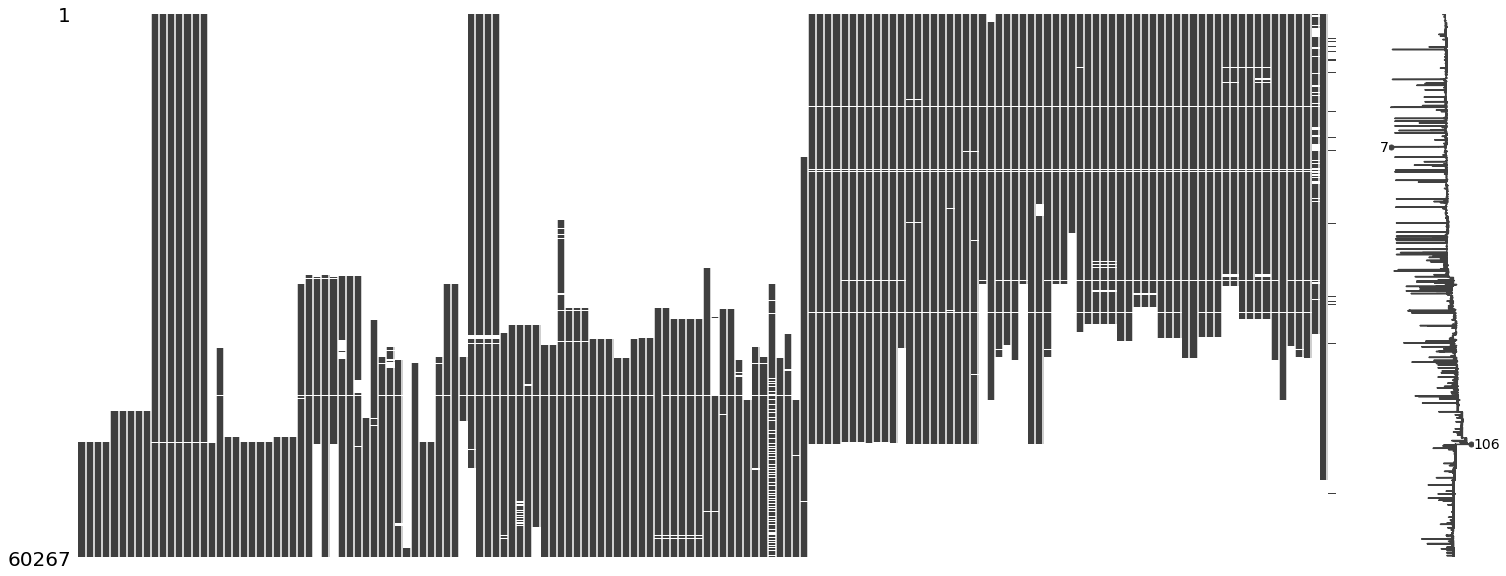

In [ ]:
matrix(df_cold_wide)

In [ ]:
df_heating = pd.read_csv('C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Drainage data/hotwater.csv')
df_heating.CTime = pd.to_datetime(df_heating.CTime)
df_heating = df_heating.loc[df_heating.CTime >= datetime.datetime(2015,1,1)]
df_heating_wide = df_heating.pivot_table(values = 'Val',columns = 'Name',index = 'CTime')

rvk_columns = [col for col in df_heating_wide.columns if 'RVK' in col]
df_heating_wide = df_heating_wide.loc[:,rvk_columns]


In [ ]:
df_io = pd.concat([df_heating_wide,df_cold_wide,df_target],axis=1)

In [ ]:
# pd.Series(df_io.columns).tolist()

<AxesSubplot:>

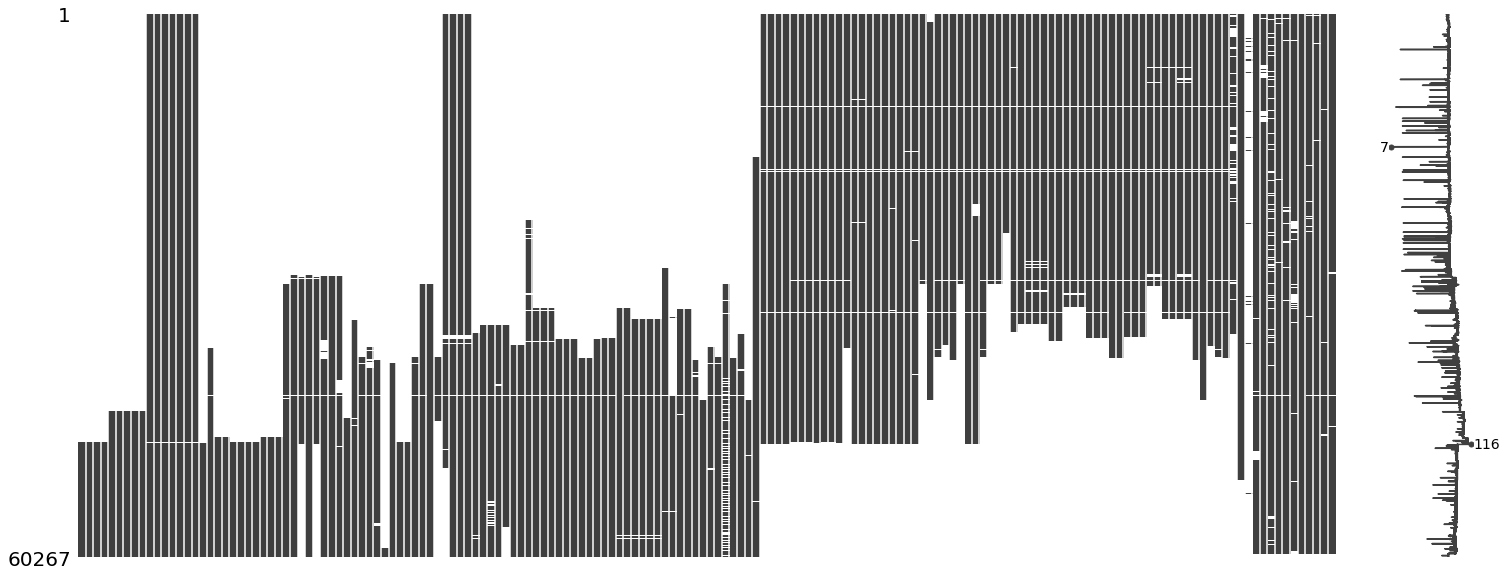

In [ ]:
from missingno import matrix 
matrix(df_io)

In [ ]:
gel_heating_corr = df_cold_wide.resample('1h').mean().apply(lambda x: x.corr(df_target.loc[:,'RVK-GEL'])).sort_values()

Name
K-RVK-049-RS211    -0.300649
K-RVK-001-RS5101   -0.233913
K-RVK-053-RS231    -0.215392
K-RVK-045-RS221    -0.206687
K-RVK-115-RS211    -0.194614
                      ...   
K-RVK-046-RS211     0.176302
K-RVK-004-RS114     0.186468
K-RVK-001-RS114     0.198589
K-RVK-084-RS111     0.201685
K-RVK-001-RS212     0.207557
Length: 87, dtype: float64

In [ ]:
df_heating = pd.read_csv('C:/Users/sverrirhd/OneDrive - Orkuveita Reykjavíkur/Verkefni/Sumarvinna/Notebooks/Data/allir_heitir.csv')

<AxesSubplot:xlabel='Name'>

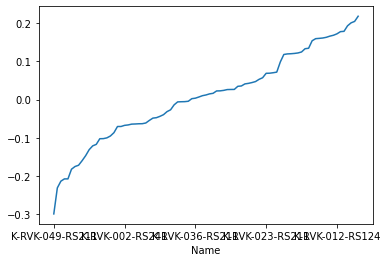

In [ ]:
gel_corr.sort_values().plot()

<AxesSubplot:>

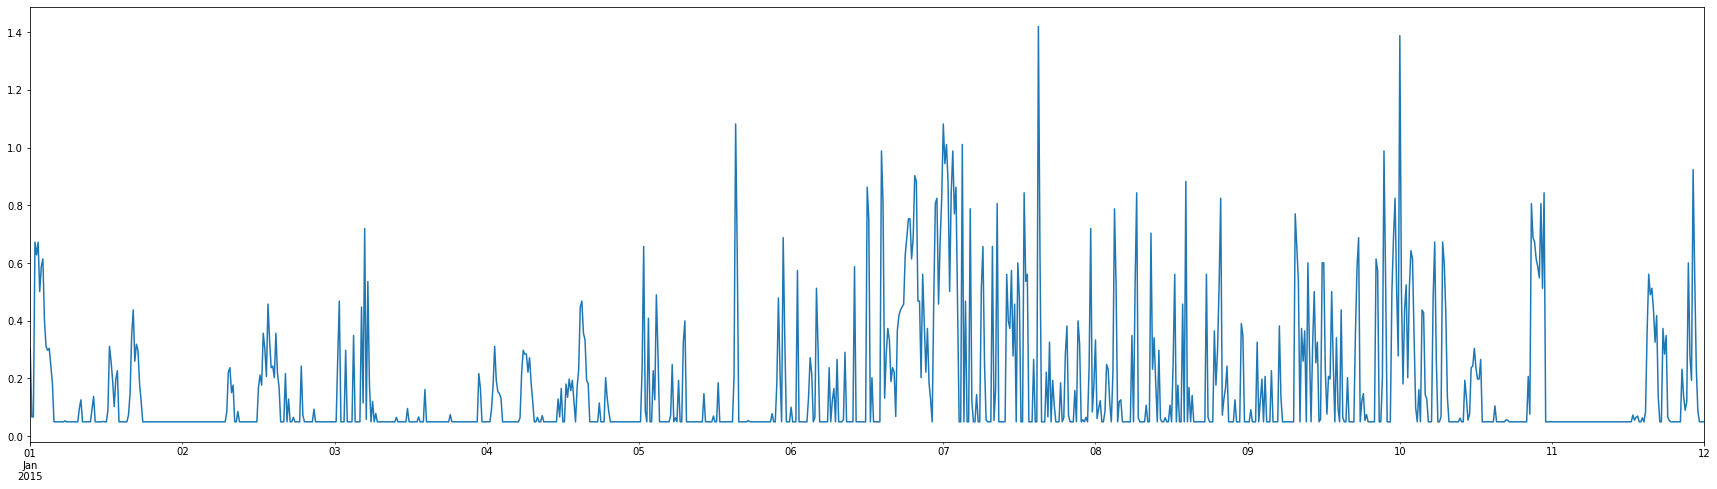

In [ ]:
plt.figure(figsize=(30,8))
df_radar.loc[d_start:d_end,220].plot()

In [ ]:
df_radar.iloc[:,220][:100].index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 00:15:00',
               '2015-01-01 00:30:00', '2015-01-01 00:45:00',
               '2015-01-01 01:00:00', '2015-01-01 01:15:00',
               '2015-01-01 01:30:00', '2015-01-01 01:45:00',
               '2015-01-01 02:00:00', '2015-01-01 02:15:00',
               '2015-01-01 02:30:00', '2015-01-01 02:45:00',
               '2015-01-01 03:00:00', '2015-01-01 03:15:00',
               '2015-01-01 03:30:00', '2015-01-01 03:45:00',
               '2015-01-01 04:00:00', '2015-01-01 04:15:00',
               '2015-01-01 04:30:00', '2015-01-01 04:45:00',
               '2015-01-01 05:00:00', '2015-01-01 05:15:00',
               '2015-01-01 05:30:00', '2015-01-01 05:45:00',
               '2015-01-01 06:00:00', '2015-01-01 06:15:00',
               '2015-01-01 06:30:00', '2015-01-01 06:45:00',
               '2015-01-01 07:00:00', '2015-01-01 07:15:00',
               '2015-01-01 07:30:00', '2015-01-01 07:45:00',
               '2015-01-

(-0.1, 5.0)

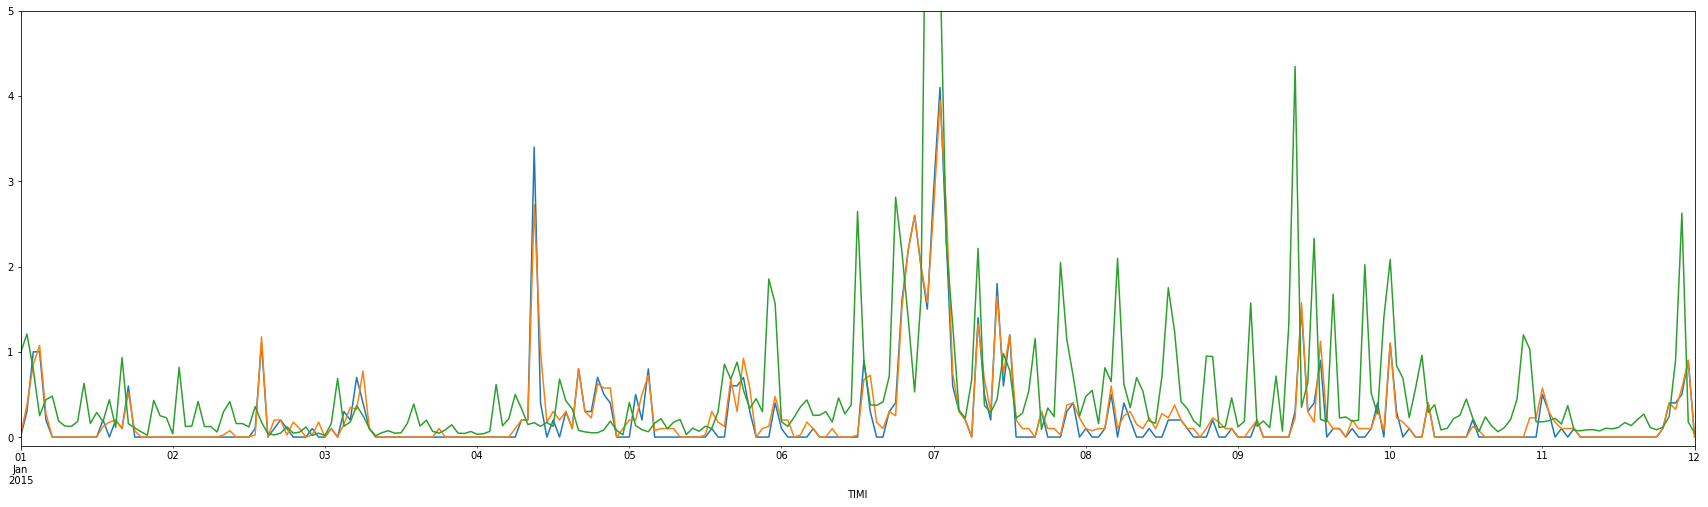

In [15]:
d_start,d_end = datetime.datetime(2015,1,1),datetime.datetime(2015,1,12)

power = 1#.6
plt.figure(figsize=(30,8))
(df_gauge.loc[:,'1475_R_manual']).plot()
(df_gauge.loc[:,'1475_R_raw'].shift(1)/2).plot()
((df_radar.loc[d_start:d_end,210]**power).resample('1h').sum()).plot()
# ((df_radar.loc[d_start:d_end,210]**power)).plot(alpha=0.5,linestyle='--')


plt.xlim(d_start,d_end)
plt.ylim(-0.1,5)

In [13]:
from sklearn.svm import SVR


In [18]:
full_res_values_tmp = df_radar.loc[:datetime.datetime(2016,12,31),[189,190,191,209,210,211,229,230,231]].shift(shift).resample('900s').mean().resample('1h').apply(lambda x : list(x)).iloc[:-1]

(17520, 9, 4)

In [19]:
df_full_res_values = pd.DataFrame(np.array([list(i) for i in full_res_values_tmp.values]).reshape(-1,9*4),index = full_res_values_tmp.index)

# .shift(shift).resample('900s').mean().resample('1h').apply(lambda x : list(x)).iloc[:-1]
df_full_res_values

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,0.025814,0.072754,0.061215,0.129377,0.014516,0.043337,0.036463,0.115307,0.034424,0.001153,...,0.193578,0.057790,0.064842,0.081631,0.001294,0.025814,0.043337,0.025814,0.000486,0.017253
2015-01-01 02:00:00,0.068684,0.217198,0.409125,0.409125,0.043337,0.230068,0.409125,0.433367,0.086468,0.086468,...,0.306801,0.386239,0.030680,0.230068,0.324980,0.344236,0.025814,0.230068,0.324980,0.409125
2015-01-01 03:00:00,0.612148,0.077065,0.081631,0.036463,0.648420,0.048625,0.048625,0.018275,0.577905,0.364633,...,0.230068,0.091592,0.648420,0.364633,0.091592,0.057790,0.612148,0.433367,0.086468,0.036463
2015-01-01 04:00:00,0.045905,0.018275,0.014516,0.003862,0.024370,0.009702,0.007706,0.002172,0.048625,0.028964,...,0.004590,0.006868,0.064842,0.023007,0.002896,0.003442,0.036463,0.018275,0.002172,0.007275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,0.072754,0.153765,0.010277,1.537646,0.040913,0.172527,0.009702,1.451631,0.217198,0.145163,...,0.021720,1.827495,0.145163,0.054558,0.364633,1.725267,0.182750,0.040913,0.324980,2.581406
2016-12-30 20:00:00,0.014516,0.005779,0.015376,0.005151,0.010277,0.004091,0.013704,0.004091,0.048625,0.001452,...,0.008647,0.021720,0.344236,0.003646,0.001370,0.001370,0.364633,0.006868,0.001936,0.001725
2016-12-30 21:00:00,0.034424,0.043337,0.025814,0.006868,0.040913,0.045905,0.016288,0.009702,0.017253,0.014516,...,0.025814,0.006484,0.057790,0.002734,0.025814,0.002301,0.048625,0.001827,0.032498,0.003646
2016-12-30 22:00:00,0.007275,0.004862,0.012214,0.002172,0.004091,0.005779,0.009159,0.002581,0.001827,0.002437,...,0.008647,0.005151,0.002172,0.000916,0.001936,0.001936,0.003646,0.001089,0.003862,0.005151


In [20]:
shift = 4
power = 1

d_end = datetime.datetime(2016,12,31)
# full_res_values_tmp = df_radar.loc[:datetime.datetime(2016,12,31),210].shift(shift).resample('900s').mean().resample('1h').apply(lambda x : list(x)).iloc[:-1]
# df_full_res_values = pd.DataFrame(np.array([i for i in full_res_values_tmp.values]),index = full_res_values_tmp.index)
# full_res_values_tmp = df_radar.loc[:d_end,[189,190,191,209,210,211,229,230,231]].shift(shift).resample('900s').mean().resample('1h').apply(lambda x : list(x)).iloc[:-1]


# full_res_values_tmp = df_radar.loc[:d_end,:].resample('900s').mean().iloc[:-1] .resample('1h').mean()
full_res_values_tmp = df_radar.loc[:d_end,:].resample('900s').mean().iloc[:-1] .resample('1h').mean()
index,values = full_res_values_tmp.index,full_res_values_tmp.values
df_all_hourly_values = pd.DataFrame(values.reshape(-1,400*4),index = index[::4])



In [22]:
# plt.imshow(all_corr[-1,:-1].reshape(20,20))
# plt.colorbar()

In [27]:
shift = 4
power = 1#1.7

d_end = datetime.datetime(2016,12,31)
# d_end = datetime.datetime(2015,3,20)


full_res_values_tmp = df_radar.loc[:d_end,[189,190,191,209,210,211,229,230,231]].resample('900s').mean().shift(shift).resample('1h').mean()#.apply(lambda x : list(x)).iloc[:-1]
df_full_res_values = pd.DataFrame(np.array([list(i) for i in full_res_values_tmp.values]).reshape(-1,9),index = full_res_values_tmp.index)

x_gauge = df_gauge.loc[:,'1475_R_manual'].dropna()
# x_gauge = df_gauge.loc[:,'1475_R_raw'].dropna()
x_radar = df_full_res_values.loc[:d_end].dropna()**power
# x_radar = ((df_radar.loc[:datetime.datetime(2016,12,31),210]).resample('300s').mean().shift(12)).resample('1h').sum()
xy_indx = x_gauge.index.intersection(x_radar.index)
x = x_radar.loc[xy_indx].values
y = x_gauge.loc[xy_indx].values.reshape(-1,1)

# all_corr = np.corrcoef(x,y,rowvar=False)
# print(all_corr)
# print(np.corrcoef(x.sum(axis=1),y,rowvar=False))

reg = Ridge()

n = len(x)
x_train = x[:n//2]
x_test = x[n//2:]
y_train = y[:n//2]
y_test = y[n//2:]
reg.fit(x_train,y_train)
y_test_pred = reg.predict(x_test)
y_train_pred = reg.predict(x_train)
print(np.corrcoef(y_test_pred.ravel(),y_test.ravel()))
print(np.corrcoef(y_train_pred.ravel(),y_train.ravel()))

[[1.         0.70464089]
 [0.70464089 1.        ]]
[[1.         0.72395753]
 [0.72395753 1.        ]]


In [42]:
shift = 4
power = 1#.7

d_end = datetime.datetime(2018,12,31)
# d_end = datetime.datetime(2015,3,20)


full_res_values_tmp = df_radar.loc[:d_end,[189,190,191,209,210,211,229,230,231]].resample('900s').mean().shift(shift).resample('1h').apply(lambda x : list(x)).iloc[:-1]
df_full_res_values = pd.DataFrame(np.array([list(i) for i in full_res_values_tmp.values]).reshape(-1,4*9),index = full_res_values_tmp.index)

x_gauge = df_gauge.loc[:,'1475_R_manual'].dropna()
# x_gauge = df_gauge.loc[:,'1475_R_raw'].dropna()
x_radar = df_full_res_values.loc[:d_end].dropna()**power
# x_radar = ((df_radar.loc[:datetime.datetime(2016,12,31),210]).resample('300s').mean().shift(12)).resample('1h').sum()
xy_indx = x_gauge.index.intersection(x_radar.index)
x = x_radar.loc[xy_indx].values
y = x_gauge.loc[xy_indx].values.reshape(-1,1)

# all_corr = np.corrcoef(x,y,rowvar=False)
# print(all_corr)
# print(np.corrcoef(x.sum(axis=1),y,rowvar=False))

reg = Ridge()

n = len(x)
x_train = x[:n//2]
x_test = x[n//2:]
y_train = y[:n//2]
y_test = y[n//2:]
reg.fit(x_train,y_train)
y_test_pred = reg.predict(x_test)
y_train_pred = reg.predict(x_train)
print(np.corrcoef(y_test_pred.ravel(),y_test.ravel()))
print(np.corrcoef(y_train_pred.ravel(),y_train.ravel()))

[[1.         0.70736977]
 [0.70736977 1.        ]]
[[1.         0.72898734]
 [0.72898734 1.        ]]


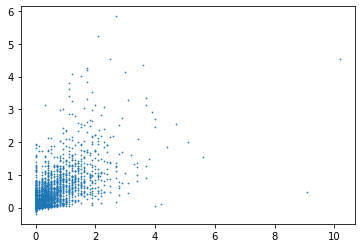

In [48]:
plt.scatter(y_test,y_test_pred,s = 0.5)

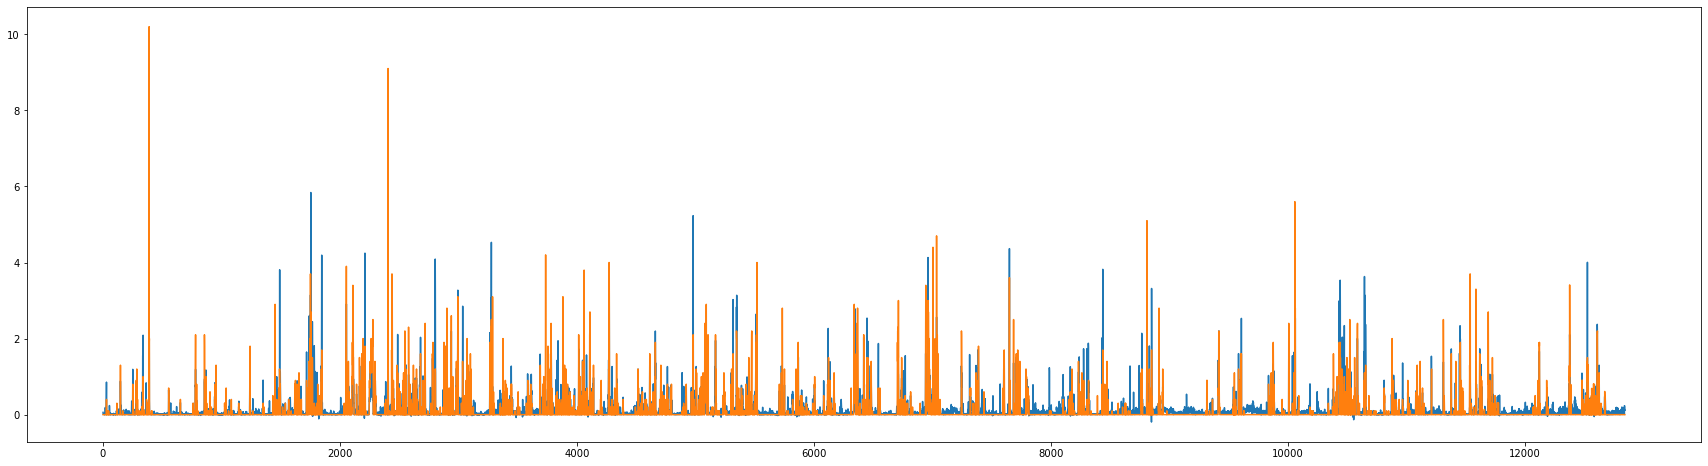

In [44]:
plt.figure(figsize=(30,8))
plt.plot(y_test_pred)
plt.plot(y_test)
# plt.xlim(0,2000)

In [30]:
def ohe_time_of_day_from_index(index):
    def get_future_hour(x): return (
        x.index + datetime.timedelta(hours=int(x.name))).hour
    
    future_hours_raw = index.apply(get_future_hour).values.ravel()
    hour_ohe_seq = OneHotEncoder().fit_transform(future_hours_raw.reshape(-1, 1))
    hour_ohe_seq = hour_ohe_seq.toarray().reshape(-1, 24)
    return hour_ohe_seq

# ohe_time_of_day_from_index(xy_indx)

In [38]:
shift = 4
power = 1#.7

d_end = datetime.datetime(2016,12,31)
# d_end = datetime.datetime(2015,3,20)

shift_x = 4

full_res_values_tmp = df_radar.loc[:d_end,[189+shift_x,
                                           190+shift_x,
                                           191+shift_x,
                                           209+shift_x,
                                           210+shift_x,
                                           211+shift_x,
                                           229+shift_x,
                                           230+shift_x,
                                           231+shift_x]
].resample('900s').mean().shift(shift).resample('1h').apply(lambda x : list(x)).iloc[:-1]
stacked_values = np.array([list(i) for i in full_res_values_tmp.values])
stacked_values = np.transpose(stacked_values,(0,2,1))
print(stacked_values.shape)
df_full_res_values = pd.DataFrame(stacked_values.reshape(-1,4*9),index = full_res_values_tmp.index)

# x_gauge = df_gauge.loc[:,'1475_R_manual'].dropna()
x_gauge = df_target.loc[:,'RVK-GEL'].dropna()
# x_gauge = df_gauge.loc[:,'1475_R_raw'].dropna()
x_radar = df_full_res_values.loc[:d_end].dropna()**power
# x_radar = ((df_radar.loc[:datetime.datetime(2016,12,31),210]).resample('300s').mean().shift(12)).resample('1h').sum()
xy_indx = x_gauge.index.intersection(x_radar.index)
hour_ohe = OneHotEncoder().fit_transform(np.array(xy_indx.hour).reshape(-1, 1))

x = np.c_[x_radar.loc[xy_indx].values]


# y = x_gauge.loc[xy_indx].values.reshape(-1,1)
y = x_gauge.loc[xy_indx].values.reshape(-1,1)

# all_corr = np.corrcoef(x,y,rowvar=False)
# print(all_corr)
# print(np.corrcoef(x.sum(axis=1),y,rowvar=False))


(17520, 4, 9)


In [957]:
# y_Series = pd.Series(y.ravel(),xy_indx)
# y_day_and_rain = (y_Series - y_Series.rolling(24).min())
# y_day_and_rain.plot()

In [932]:
# plt.plot(y - pd.Series(y.ravel(),xy_indx).rolling(24).mean())

In [35]:
# reg_preproc = LinearRegression()
# reg_preproc.fit(hour_ohe[24:],y_day_and_rain.values.ravel()[24:])
# y_pred = reg_preproc.predict(hour_ohe)

In [947]:
y

NameError: name 'yy_pred' is not defined

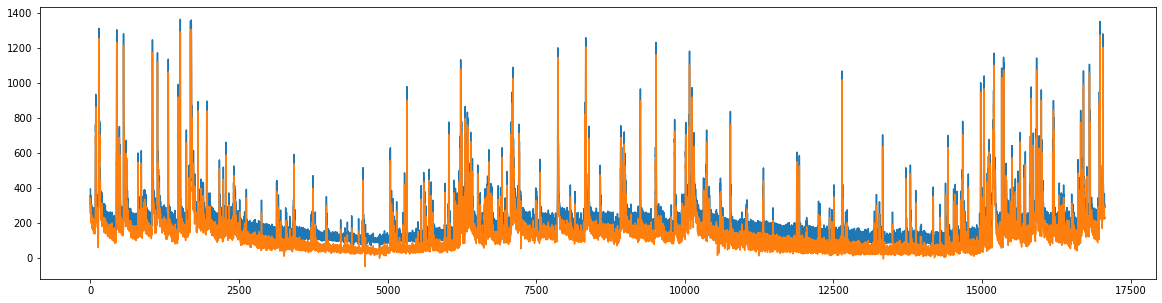

In [956]:
plt.figure(figsize=(20,5))
plt.plot(y)
plt.plot(y.ravel() - y_pred.ravel())
plt.xlim(2500,2800)

In [890]:
n = len(x)
x_train = x[:n//2]
x_test = x[n//2:]
y_train = y[:n//2]
y_test = y[n//2:]

In [891]:
x_train.shape

(8535, 36)

In [964]:
# with tf.device('/cpu:0'):
#     reg = tf.keras.Sequential([Input((4*9,),batch_size=1),Reshape((4,9)),LSTM(100),Dense(1)])
#     reg.compile(loss = tf.keras.losses.MSE, optimizer = tf.keras.optimizers.Adam())
#     reg.fit(x_train,y_train,validation_data = (x_test,y_test),batch_size=1,epochs = 10)

In [900]:
y_test_pred = reg.predict(x_test,batch_size=1)

InvalidArgumentError:  Input to reshape is a tensor with 1152 values, but the requested shape has 36
	 [[node sequential_14/reshape_13/Reshape (defined at \SVERRI~1\AppData\Local\Temp/ipykernel_42964/2945813198.py:5) ]] [Op:__inference_predict_function_17354]

Function call stack:
predict_function


In [901]:
y_train_pred = reg.predict(x_train,batch_size=1)

In [902]:
print(np.corrcoef(y_test_pred.ravel(),y_test.ravel()))
print(np.corrcoef(y_train_pred.ravel(),y_train.ravel()))

[[1.         0.47199759]
 [0.47199759 1.        ]]
[[1.         0.41538231]
 [0.41538231 1.        ]]


In [903]:
np.mean((y_test_pred - y_test)**2)

28882.913673085168

In [863]:

print(np.mean((y_test_pred.ravel()-y_test.ravel())**2))

11409.959958198624


(0.0, 2000.0)

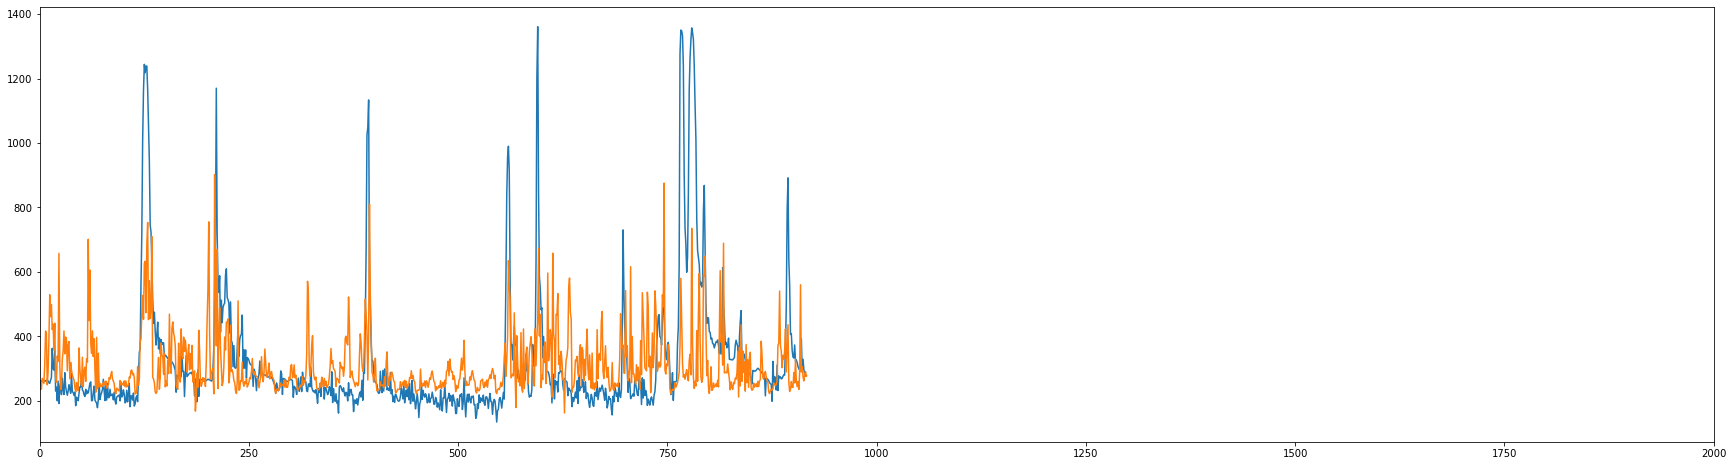

In [861]:
plt.figure(figsize=(30,8))
plt.plot(y_test)
plt.plot(y_test_pred)
plt.xlim(0,2000)

In [841]:
# x_gauge = df_gauge.loc[:,'1475_R_manual'].dropna()
# # x_gauge = df_gauge.loc[:,'1475_R_raw']
# y_radar = ((df_radar.loc[:datetime.datetime(2016,12,31),210]).resample('300s').mean().shift(12)).resample('1h').sum()
# xy_indx = x_gauge.index.intersection(y_radar.index)
# plt.scatter(x_gauge.loc[xy_indx],y_radar.loc[xy_indx],s = 0.1)
# plt.plot([0,10],[0,10])
# # plt.yscale('log')
# # plt.xscale('log')
# plt.xlim(0.01,10)
# plt.ylim(0.01,10)
# # 0.611777796653367
# # y_radar = ((df_radar.loc[:,210]**(1.8)).resample('600s').mean().shift(7)).resample('1h').sum()
# # 0.6300805242120469
# # y_radar = ((df_radar.loc[:datetime.datetime(2016,12,31),210]).resample('600s').mean().shift(7)**1.7).resample('1h').sum()
# x_gauge.corr(y_radar)

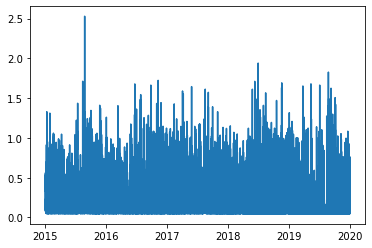

In [ ]:
# plt.plot(df_radar.loc[:,210].resample('1h').mean().rolling(24*7).mean())
plt.plot(df_radar.loc[:,210].resample('600s').mean().resample('1800s').mean())

In [50]:
df.loc[:,'RVK-GEL'].corr(df.loc[:,'rain'])

NameError: name 'df' is not defined

In [51]:
df = df_target.loc[:,'RVK-GEL'].interpolate()
df = pd.DataFrame(df)
df.loc[:,'year'] = df.index.year
df.loc[:,'month'] = df.index.month
df.loc[:,'hour'] = df.index.hour
df.loc[:,'weekday'] = df.index.weekday
df.loc[:,'timestamp'] = df.index

df.loc[:,'avg_hour_day'] = df.weekday.astype(str) + ' ' + df.hour.astype(str)
df.loc[:,'avg_hour_day'] = df.loc[:,'avg_hour_day'].replace(df[:20000].groupby(df.weekday.astype(str) + ' ' + df.hour.astype(str))['RVK-GEL'].mean())
df['Weekday'] = df.timestamp.dt.weekday
df['day_time'] = ((df['hour'] >= 6) & (df['hour'] <= 22)).astype(int)

common_indexes = df_gauge.index.intersection(df.index)

df.loc[:,'rain'] = df_gauge.loc[:,'1475_R_manual'].shift(1).interpolate()

df = df.reset_index()

In [52]:
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler()
scaled_data = standard_scaler.fit_transform(df[['hour', 'day_time', 'weekday', 'avg_hour_day', 'RVK-GEL','rain']])

scaled_df = df.copy()
scaled_df['hour'] = scaled_data[:,0]
scaled_df['day_time'] = scaled_data[:,1]
scaled_df['weekday'] = scaled_data[:,2]
scaled_df['avg_hour_day'] = scaled_data[:,3]
scaled_df['RVK-GEL'] = scaled_data[:,4]
scaled_df['rain'] = scaled_data[:,5]
scaled_df.head(3)


,CTime,RVK-GEL,year,month,hour,weekday,timestamp,avg_hour_day,Weekday,day_time,rain
0,2015-01-01 00:00:00,1.140936,2015,1,-1.661131,-0.00076,2015-01-01 00:00:00,0.385331,3,-1.55817,-0.266304
1,2015-01-01 01:00:00,1.772293,2015,1,-1.516680,-0.00076,2015-01-01 01:00:00,-0.024273,3,-1.55817,-0.266304
2,2015-01-01 02:00:00,0.947104,2015,1,-1.372229,-0.00076,2015-01-01 02:00:00,-0.665718,3,-1.55817,0.589373


In [53]:
# Specifying how many values to predict
time_step = 1

In [96]:
training_size = int(len(scaled_df) * 0.5)
training, testing = scaled_df[0:training_size], scaled_df[training_size:len(df)]
print('Size of the dataset: %d' % (len(scaled_df)))
print('Training examples: %d' % (len(training)))
print('Testing examples: %d' % (len(testing)))

Size of the dataset: 59875
Training examples: 29937
Testing examples: 29938


In [112]:
# training features: Value, Hour, day_time
# X_train_ = training[['RVK-GEL', 'hour', 'day_time','rain']].to_numpy()
X_train_ = training[['hour', 'day_time','rain']].to_numpy()
# X_train_ = training[['RVK-GEL']].to_numpy()
y_train_ = scaled_df[time_step:testing.index[0]]['RVK-GEL'].to_numpy()
# testing data
# X_test_ = testing[0:-time_step][['RVK-GEL', 'hour', 'day_time','rain']].to_numpy()
X_test_ = testing[0:-time_step][['hour', 'day_time','rain']].to_numpy()
# X_test_ = testing[0:-time_step][['RVK-GEL']].to_numpy()
y_test_ = scaled_df[testing.index[0] + time_step:]['RVK-GEL'].to_numpy()

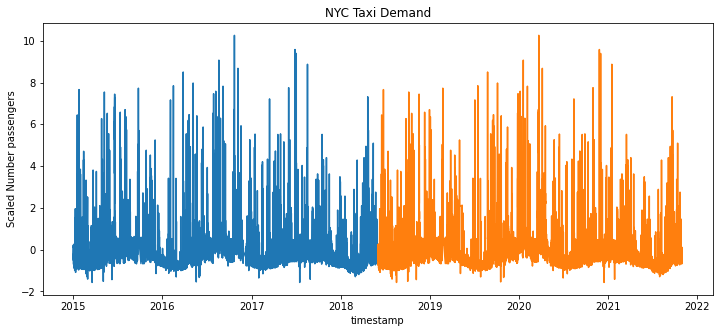

In [122]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training['timestamp'], y_test_)
ax.plot(testing['timestamp'][0:-1], y_test_)
ax.set_title('NYC Taxi Demand')
plt.xlabel('timestamp')
plt.ylabel('Scaled Number passengers')
plt.show()

In [123]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asarray(data_sequences)

In [124]:
# lag_values_to_test = np.unique((2**np.linspace(0,11,40)).astype(int))
lag_values_to_test = np.unique((2**np.linspace(0,8,20)).astype(int))
lag_values_to_test

array([  1,   2,   3,   4,   5,   7,  10,  13,  18,  24,  33,  44,  59,
        79, 106, 142, 191, 256])

In [125]:
# X_train

In [126]:
# X_test[test_not_nans].reshape(-1,prev_values*4).shape

In [128]:
MSES = []
for prev_values in lag_values_to_test:
    # prev_values = 168
    X_train = create_sequence(X_train_, prev_values)
    X_test  = create_sequence(X_test_, prev_values)
    y_train = y_train_[-X_train.shape[0]:]
    y_test  = y_test_[-X_test.shape[0]:]

    reg = Ridge()

    test_not_nans = ~np.any(np.isnan(X_test),axis=(1,2))


    reg.fit(X_train.reshape(-1,prev_values*3),y_train)
    # reg.fit(X_train.reshape(-1,prev_values*4),y_train)
    # reg.fit(X_train.reshape(-1,prev_values),y_train)
    # y_pred = reg.predict(X_test[test_not_nans].reshape(-1,prev_values*4))
    y_pred = reg.predict(X_test[test_not_nans].reshape(-1,prev_values*3))
    # y_pred = reg.predict(X_test[test_not_nans].reshape(-1,prev_values))

    s = standard_scaler.scale_[-2]
    m = standard_scaler.mean_[-2]
    mse = np.mean(((y_pred * s + m)- (y_test[test_not_nans] * s + m))**2)
    print(prev_values,mse)
    MSES.append(mse)


1 8264.068365182959
2 8186.765470444567
3 8129.683989646923
4 8103.723469558256
5 8084.389575536202
7 8040.90817281432
10 8027.8924961506
13 8006.217942275076
18 7978.562544769133
24 7932.708975053641
33 7932.76200747305
44 7920.265724843684
59 7950.660790221582
79 7945.478705581323
106 7933.263817424457
142 7936.882032877313
191 8005.268484385245
256 8036.997196456782


Text(0.5, 0, 'Number of observations allowed')

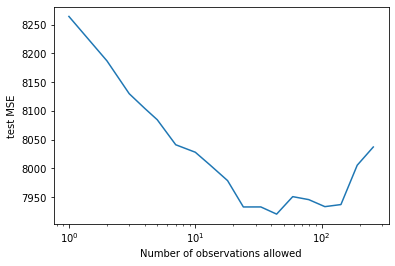

In [129]:
plt.plot(lag_values_to_test,MSES)
plt.xscale('log')
plt.ylabel('test MSE')
plt.xlabel('Number of observations allowed')

In [69]:

prev_values = 1200
X_train = create_sequence(X_train_, prev_values)
X_test  = create_sequence(X_test_, prev_values)
y_train = y_train_[-X_train.shape[0]:]
y_test  = y_test_[-X_test.shape[0]:]

reg = Ridge()

test_not_nans = ~np.any(np.isnan(X_test),axis=(1,2))


reg.fit(X_train.reshape(-1,prev_values*4),y_train)
y_pred = reg.predict(X_test[test_not_nans].reshape(-1,prev_values*4))

s = standard_scaler.scale_[-2]
m = standard_scaler.mean_[-2]

y_pred = y_pred * s + m
y_true = y_test[test_not_nans] * s + m

mse = np.mean((y_pred-y_true)**2)
print(prev_values,mse)

1200 4867.910890307516


In [175]:
thresholds = np.array([[   0,  100,  200,  300,  400,  600,  800, 1000],
       [   0,   25,   50,   75,  100,  125,  150,  200]])

In [176]:
Y_val_cls = np.zeros(y_pred.shape + (8,))
for i, (t1, t2) in enumerate(thresholds.T):
    Y_val_cls[:, i] = (y_true > t1)*1

In [177]:
def CLF_error(Y, Y_pred, thresh):
    Y_bool = Y == 1
    Y_pred_bool = Y_pred > thresh
    TP = np.sum(Y_bool & Y_pred_bool, axis=0)  # True True
    FP = np.sum(~Y_bool & Y_pred_bool, axis=0)  # False True
    TN = np.sum(~Y_bool & ~Y_pred_bool, axis=0)  # False False
    FN = np.sum(Y_bool & ~Y_pred_bool, axis=0)  # True False
    return TP, FP, TN, FN

In [178]:
# plt.plot(y_trues_val*1000)
# plt.plot(y_pred)

In [179]:
eta = 1e-7

thresh = 4

y_trues_val = Y_val_cls[:, thresh]
y_preds_val = y_pred

performance_dict_val = {}
performance_dict_val['CSI'] = []
performance_dict_val['precision'] = []
performance_dict_val['recall'] = []
performance_dict_val['false positive rate'] = []
performance_dict_val['false negative rate'] = []
performance_dict_val['true positive rate'] = []
performance_dict_val['f1'] = []
performance_dict_val['pred_thresh'] = []

prediction_thresholds = np.linspace(0,1500,2000)
for pred_thresh in prediction_thresholds:
    TP, FP, TN, FN = CLF_error(y_trues_val, y_preds_val, pred_thresh)
    performance_dict_val['CSI'].append(TP/(TP + FP + FN + eta))
    performance_dict_val['precision'].append(TP/(TP+FP + eta))
    performance_dict_val['recall'].append(TP/(TP+FN + eta))
    performance_dict_val['false positive rate'].append(FP/(FP+TN + eta))
    performance_dict_val['true positive rate'].append(TP/(TP+FN + eta))
    performance_dict_val['f1'].append(TP/(TP + 1/2*(FP+FN + eta)))
    # performance_dict_val['false positive rate'].append(FN/(TP+FP))

    
    performance_dict_val['pred_thresh'].append(pred_thresh)
    

performance_dict_val['y_trues_val'] = y_trues_val
performance_dict_val['y_preds_val'] = y_preds_val



Text(0.5, 0, 'Recall')

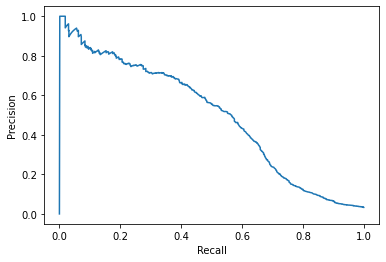

In [180]:
precision_val = np.array(performance_dict_val['precision'])
recall_val = np.array(performance_dict_val['recall'])
FPR_val = np.array(performance_dict_val['false positive rate'])
# precision_val = stats_dict['precision_val']

plt.plot(recall_val,precision_val)

# len(iop)
# no_skill = len(y_true_val[y_true_val==1]) / len(y_true_val)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.ylabel('Precision')
plt.xlabel('Recall')



Text(0.5, 1.0, 'ROC curve')

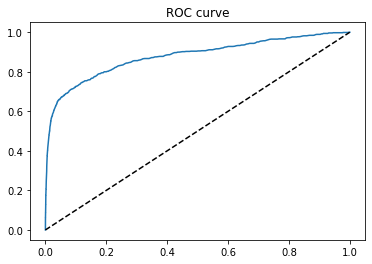

In [181]:
plt.plot(FPR_val.T,recall_val.T)
plt.plot([0,1],[0,1],linestyle='--',color='black')
plt.title('ROC curve')

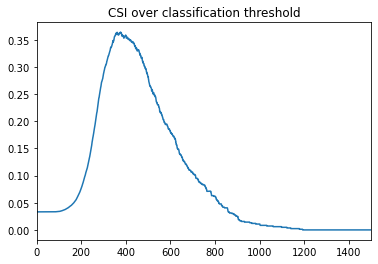

In [188]:
CSI_val = np.array(performance_dict_val['CSI'])

plt.plot(np.linspace(0,1500,2000),CSI_val.T)
plt.xlim(0,1500)
plt.title('CSI over classification threshold')
plt.show()


In [23]:
# fig, ax = plt.subplots(figsize=(12, 5))
# ax.plot(training[0:48]['timestamp'], X_train[0,:,0])
# ax.scatter(training[48:49]['timestamp'], y_train[0], color='red', linewidth=5.0)
# ax.set_title('NYC Taxi Demand')
# plt.xlabel('timestamp')
# plt.ylabel('Scaled Number passengers')
# plt.show()


ValueError: x and y must have same first dimension, but have shapes (48,) and (1200,)

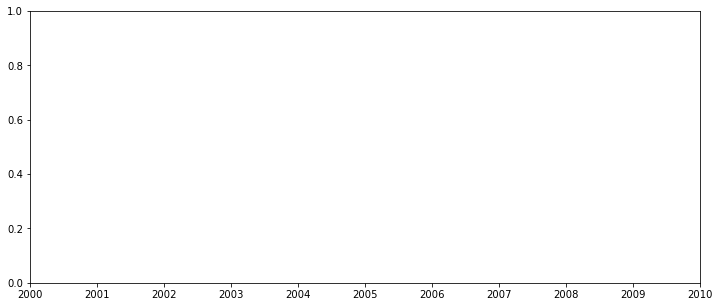

In [183]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(training[1:49]['timestamp'], X_train[1,:,0])
ax.scatter(training[48:49]['timestamp'], y_train[0], color='green', linewidth=5.0)
ax.scatter(training[49:50]['timestamp'], y_train[1], color='red', linewidth=5.0)
ax.set_title('NYC Taxi Demand')
plt.xlabel('timestamp')
plt.ylabel('Scaled Number passengers')
plt.show()

In [ ]:
print("X_train shape={}, and y_train shape={}".format(X_train.shape, y_train.shape))
print("X_test shape={}, and y_test shape={}".format(X_test.shape, y_test.shape))

X_train shape=(53815, 24, 48, 4), and y_train shape=(53815,)
X_test shape=(5915, 24, 48, 4), and y_test shape=(5915,)


In [1220]:
test_not_nans = ~np.any(np.isnan(X_test),axis=(1,2))


In [1221]:
from tensorflow.keras import Sequential
with tf.device('/cpu:0'):
    model = Sequential()
    model.add(LSTM(64,return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[-1])))
    model.add(Dropout(0.5))
    model.add(LSTM(20,return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop')
    history = model.fit(X_train, y_train,validation_data = (X_test[test_not_nans],y_test[test_not_nans]),batch_size=128, epochs=50)

Epoch 1/50
421/421 [==============================] - 15s 29ms/step - loss: 0.4501 - val_loss: 0.3311
Epoch 2/50
421/421 [==============================] - 12s 29ms/step - loss: 0.3439 - val_loss: 0.3191
Epoch 3/50
421/421 [==============================] - 13s 30ms/step - loss: 0.3247 - val_loss: 0.3056
Epoch 4/50
421/421 [==============================] - 13s 31ms/step - loss: 0.3181 - val_loss: 0.3031
Epoch 5/50
421/421 [==============================] - 15s 35ms/step - loss: 0.3169 - val_loss: 0.3046
Epoch 6/50
421/421 [==============================] - 14s 34ms/step - loss: 0.3180 - val_loss: 0.2990
Epoch 7/50
421/421 [==============================] - 14s 32ms/step - loss: 0.3157 - val_loss: 0.2973
Epoch 8/50
421/421 [==============================] - 14s 33ms/step - loss: 0.3178 - val_loss: 0.3023
Epoch 9/50
421/421 [==============================] - 13s 31ms/step - loss: 0.3129 - val_loss: 0.3042
Epoch 10/50
421/421 [==============================] - 14s 32ms/step - loss: 0.316

KeyboardInterrupt: 

3810.01542342997

In [1223]:
# Training the model


In [1224]:
def evaluate_predictions(predictions, y_test, outliers):
    ratio = []
    differences = []
    for pred in range(len(y_test)):
        ratio.append((y_test[pred]/predictions[pred])-1)
        differences.append(abs(y_test[pred]- predictions[pred]))
    
    
    n_outliers = int(len(differences) * outliers)
    outliers = pd.Series(differences).astype(float).nlargest(n_outliers)
    
    return ratio, differences, outliers

In [1225]:
# create the list of difference between prediction and test data
predictions = model.predict(X_test[test_not_nans])
ratio, differences, outliers = evaluate_predictions(predictions, y_test[test_not_nans], 0.01)
for index in outliers.index: 
    outliers[index] = predictions[index]
print(len(outliers))
outliers

23


487    -0.003312
611     0.157056
453    -0.077310
916     3.828583
614     4.220683
613     4.165780
2241    0.023967
914     1.059431
461     0.349134
913     0.950694
142     0.077691
488    -0.034385
2317   -0.519223
2280    0.271071
610    -0.210374
547     0.180446
2236    0.218331
786     0.055534
44      0.866912
30     -0.132771
720     2.423245
2282    2.198364
867    -0.085474
dtype: float64

In [1226]:
len(X_test),len(y_test)

(5963, 5963)

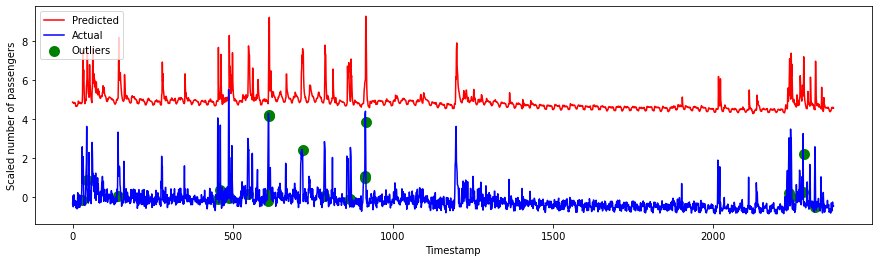

In [1227]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions+5,color='red', label='Predicted')
axs.plot(y_test[test_not_nans],color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Scaled number of passengers')
plt.legend(loc='upper left')
plt.show()

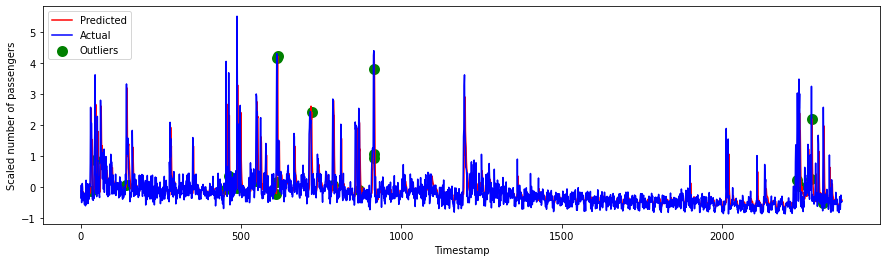

In [1228]:
# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(predictions,color='red', label='Predicted')
axs.plot(y_test[test_not_nans],color='blue', label='Actual')
axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Scaled number of passengers')
plt.legend(loc='upper left')
plt.show()

In [1229]:
# standard_scaler = preprocessing.StandardScaler()
# scaled_data = standard_scaler.fit_transform(df[['hour', 'day_time', 'weekday', 'avg_hour_day', 'RVK-GEL','rain']])
standard_scaler.inverse_transform(scaled_df[['hour', 'day_time', 'weekday', 'avg_hour_day', 'RVK-GEL','rain']])

array([[0.00000000e+00, 0.00000000e+00, 3.00000000e+00, 2.16386697e+02,
        3.24141174e+02, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 3.00000000e+00, 2.11090393e+02,
        3.94048706e+02, 0.00000000e+00],
       [2.00000000e+00, 0.00000000e+00, 3.00000000e+00, 2.02796336e+02,
        3.02678894e+02, 3.00000000e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 6.00000000e+00, 1.91939151e+02,
        1.75194494e+02,            nan],
       [1.00000000e+00, 0.00000000e+00, 6.00000000e+00, 1.91960306e+02,
        1.24244649e+02,            nan],
       [2.00000000e+00, 0.00000000e+00, 6.00000000e+00, 1.95533165e+02,
        1.26187762e+02,            nan]])

In [1230]:
s = standard_scaler.scale_[-2]
m = standard_scaler.mean_[-2]

restored_timeseries = scaled_df.loc[:,'RVK-GEL'] * s + m

restored_timeseries = scaled_df.loc[:,'RVK-GEL'] * s + m


In [1231]:
y_pred_restored = (predictions * s + m)
y_restored = (y_test[test_not_nans] * s + m)

In [1232]:
np.mean((y_pred_restored - y_restored)**2)

7538.443361644481

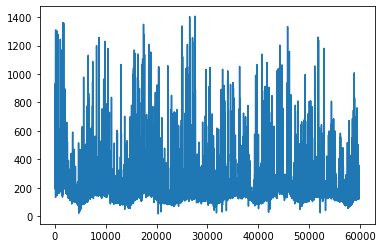

In [1233]:
plt.plot(restored_timeseries)
# plt.plot(df.loc[:,'RVK-GEL'])

In [1234]:
scaled_df.loc[:,'RVK-GEL'] / df.loc[:,'RVK-GEL']

0        0.003520
1        0.004498
2        0.003129
3        0.004063
4        0.003809
           ...   
59870   -0.001638
59871   -0.003547
59872   -0.001166
59873   -0.005347
59874   -0.005126
Name: RVK-GEL, Length: 59875, dtype: float64